# Importing Libraries

In [2]:
import os
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras.callbacks import (
    ModelCheckpoint,
    History,
    EarlyStopping,
    LearningRateScheduler,
)
from keras.applications.resnet50 import preprocess_input as piRes
from keras.models import load_model
from collections import Counter
import random
import dlib
from IPython.display import display, Image

# Analysing and Refining the Dataset

In [4]:
dataset_folder = "Dataset"

In [5]:
# Extracting images and corresponding age labels from the dataset


def read_images(folder_path):
    image_data = []
    image_labels = []

    for filename in os.listdir(folder_path):
        if (
            filename.endswith(".jpeg")
            or filename.endswith(".jpg")
            or filename.endswith(".png")
        ):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)

            age_str = filename.split("_")[0]
            try:
                age = int(age_str)
            except ValueError:
                age = None

            image_data.append(image)
            image_labels.append(age)

    return image_data, image_labels

In [6]:
images, labels = read_images(dataset_folder)

In [11]:
image_df = pd.DataFrame({"Image": images, "Age": labels})

In [12]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23709 entries, 0 to 23708
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   23709 non-null  object
 1   Age     23709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.6+ KB


In [13]:
image_df.describe()

,Age
count,23709.000000
mean,33.304652
std,19.886506
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


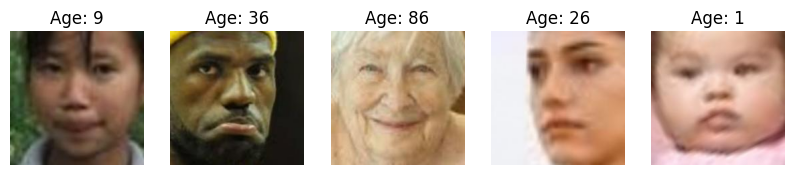

In [14]:
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Age: {labels[i]}")
    plt.axis("off")
plt.show()

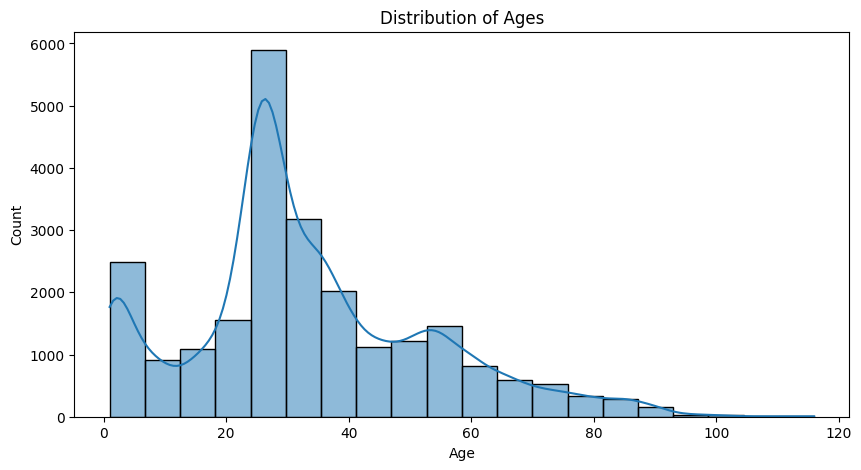

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(image_df["Age"], bins=20, kde=True)
plt.title("Distribution of Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [7]:
occurrences = Counter(labels)

aggregated_counts = {}

# Group counts for a range of 10 integers
for number in range(1, 117, 10):
    range_end = min(number + 9, 116)
    key = f"{number}-{range_end}"
    aggregated_counts[key] = sum(occurrences[i] for i in range(number, range_end + 1))

# Print the aggregated counts
for key, count in aggregated_counts.items():
    print(f"{key}: {count} times")

1-10: 3218 times
11-20: 1659 times
21-30: 7784 times
31-40: 4339 times
41-50: 2100 times
51-60: 2211 times
61-70: 1173 times
71-80: 685 times
81-90: 453 times
91-100: 66 times
101-110: 13 times
111-116: 8 times


In [16]:
aggregated_counts = {}

# Group counts for a range of 10 integers
for number in range(1, 117, 15):
    range_end = min(number + 14, 116)
    key = f"{number}-{range_end}"
    aggregated_counts[key] = sum(occurrences[i] for i in range(number, range_end + 1))

# Print the aggregated counts
for key, count in aggregated_counts.items():
    print(f"{key}: {count} times")

1-15: 3828 times
16-30: 8833 times
31-45: 5434 times
46-60: 3216 times
61-75: 1547 times
76-90: 764 times
91-105: 74 times
106-116: 13 times


In [17]:
aggregated_counts = {}

# Group counts for a range of 10 integers
for number in range(1, 117, 5):
    range_end = min(number + 4, 116)
    key = f"{number}-{range_end}"
    aggregated_counts[key] = sum(occurrences[i] for i in range(number, range_end + 1))

# Print the aggregated counts
for key, count in aggregated_counts.items():
    print(f"{key}: {count} times")

1-5: 2363 times
6-10: 855 times
11-15: 610 times
16-20: 1049 times
21-25: 2760 times
26-30: 5024 times
31-35: 2446 times
36-40: 1893 times
41-45: 1095 times
46-50: 1005 times
51-55: 1232 times
56-60: 979 times
61-65: 699 times
66-70: 474 times
71-75: 374 times
76-80: 311 times
81-85: 259 times
86-90: 194 times
91-95: 29 times
96-100: 37 times
101-105: 8 times
106-110: 5 times
111-115: 4 times
116-116: 4 times


In [8]:
original_counts = {
    "1-5": 2363,
    "6-10": 855,
    "11-15": 610,
    "16-20": 1049,
    "21-25": 2760,
    "26-30": 5024,
    "31-35": 2446,
    "36-40": 1893,
    "41-45": 1095,
    "46-50": 1005,
    "51-55": 1232,
    "56-60": 979,
    "61-65": 699,
    "66-70": 474,
    "71-75": 374,
    "76-80": 311,
    "81-85": 259,
    "86-90": 194,
    "91-95": 29,
    "96-100": 37,
    "101-105": 8,
    "106-110": 5,
    "111-115": 4,
    "116-116": 4,
}

# Define the new age ranges
new_ranges = {
    "1-15": ["1-5", "6-10", "11-15"],
    "16-25": ["16-20", "21-25"],
    "26-30": ["26-30"],
    "31-35": ["31-35"],
    "36-45": ["36-40", "41-45"],
    "46-60": ["46-50", "51-55", "56-60"],
    "60-116": [
        "61-65",
        "66-70",
        "71-75",
        "76-80",
        "81-85",
        "86-90",
        "91-95",
        "96-100",
        "101-105",
        "106-110",
        "111-115",
        "116-116",
    ],
}

# Calculate counts within each new range
new_counts = {
    new_range: sum(original_counts[old_range] for old_range in ranges)
    for new_range, ranges in new_ranges.items()
}

# Print the counts within each new range
for new_range, count in new_counts.items():
    print(f"{new_range}: {count} times")

1-15: 3828 times
16-25: 3809 times
26-30: 5024 times
31-35: 2446 times
36-45: 2988 times
46-60: 3216 times
60-116: 2398 times


#### Age prediction is a regression problem. But predicting the age accurately through regression with limited computation resources is a tough task. So we decided to convert the age prediction problem to a multiclass classification problem.
-The ranges have been defined such that the number of images in each class is nearly equal

In [9]:
# Define custom ranges
custom_ranges = [15, 25, 30, 35, 45, 60, 116]

# Encode the labels based on custom ranges
encoded_labels = [
    next((i for i, r in enumerate(custom_ranges) if label <= r), len(custom_ranges))
    for label in labels
]

# Print the original and encoded labels
print("Original Labels:", labels)
print("Encoded Labels:", encoded_labels)

Original Labels: [9, 36, 86, 26, 1, 52, 25, 16, 27, 36, 58, 6, 35, 1, 26, 2, 53, 35, 23, 24, 26, 75, 36, 23, 50, 15, 25, 37, 10, 22, 1, 29, 26, 21, 46, 52, 26, 27, 17, 63, 34, 61, 18, 29, 25, 34, 20, 32, 34, 29, 46, 36, 34, 32, 30, 32, 75, 32, 45, 26, 36, 24, 31, 31, 86, 43, 25, 26, 3, 54, 60, 25, 32, 26, 1, 36, 49, 35, 26, 24, 59, 30, 41, 46, 82, 53, 3, 27, 10, 22, 3, 36, 37, 40, 18, 35, 5, 44, 45, 35, 32, 5, 35, 21, 2, 27, 76, 58, 3, 26, 8, 28, 40, 56, 39, 4, 54, 15, 96, 1, 26, 26, 26, 28, 44, 45, 31, 40, 28, 24, 34, 26, 56, 25, 5, 26, 28, 26, 23, 1, 18, 4, 61, 26, 1, 12, 27, 40, 53, 22, 60, 25, 18, 27, 8, 26, 63, 1, 67, 75, 60, 26, 34, 34, 47, 40, 26, 26, 22, 48, 24, 19, 27, 26, 62, 44, 2, 45, 32, 47, 35, 35, 8, 27, 43, 25, 32, 38, 18, 71, 49, 36, 53, 25, 36, 50, 89, 53, 41, 21, 27, 27, 54, 59, 90, 20, 22, 60, 34, 26, 35, 4, 35, 1, 26, 22, 35, 1, 22, 36, 61, 14, 68, 20, 29, 27, 33, 26, 54, 26, 19, 28, 26, 25, 24, 56, 34, 16, 33, 25, 3, 32, 80, 42, 65, 16, 32, 50, 57, 76, 25, 44, 21,

#### Making a new dataset according to defined classes

In [12]:
base_directory = "OrganisedDataset/"

# Copy or move images to their respective class folders
for idx, (image, label) in enumerate(zip(images, encoded_labels)):
    file_name = f"image_{idx}.jpg"  # You can use any naming convention here
    destination_path = os.path.join(base_directory, str(label), file_name)

    # Save the image using OpenCV without normalization
    cv2.imwrite(destination_path, image)

#### Refining the images in the Organised Dataset to have more focus on the face (Face extraction using dlib)

In [ ]:
detector = dlib.get_frontal_face_detector()

dataset_path = "OrganisedDataset"

faces_dataset_path = "FacesDataset"

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    faces_label_path = os.path.join(faces_dataset_path, label)

    for filename in os.listdir(label_path):
        image_path = os.path.join(label_path, filename)

        img = cv2.imread(image_path)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = detector(gray)

        for i, face in enumerate(faces):
            x, y, w, h = face.left(), face.top(), face.width(), face.height()

            face_img = img[y : y + h, x : x + w]

            if not face_img.size == 0:
                save_path = os.path.join(
                    faces_label_path, f"{filename.split('.')[0]}_face_{i}.jpg"
                )
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                cv2.imwrite(save_path, face_img)

# Data Preprocessing

In [20]:
img = images[:5]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


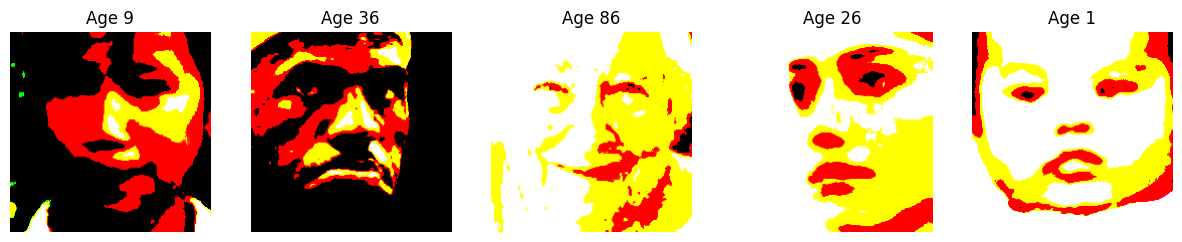

In [24]:
# Using the preproccesing function used for the ResNet50 to preprocess the images for our custom model
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, image in enumerate(img):
    preprocessed_image = piRes(image)

    axes[i].imshow(preprocessed_image)
    axes[i].axis("off")
    axes[i].set_title(f"Age {labels[i]}")

plt.show()

In [10]:
type(images[0])

numpy.ndarray

# Model Training

In [38]:
datagen = ImageDataGenerator(
    preprocessing_function=piRes, validation_split=0.2, rescale=1.0 / 255
)
train_generator = datagen.flow_from_directory(
    "FacesDataset/",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    subset="training",
)
val_generator = datagen.flow_from_directory(
    "FacesDataset/",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False,
    subset="validation",
)

Found 14878 images belonging to 7 classes.
Found 3716 images belonging to 7 classes.


In [51]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation="softmax"))

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 batch_normalization_17 (Ba  (None, 222, 222, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_18 (Ba  (None, 109, 109, 64)      256       
 tchNormalization)                                               
                                                      

In [49]:
model.compile(
    optimizer=optimizers.legacy.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [7]:
# Learning Rate Scheduler
def ls(epoch):
    return 0.001 * np.exp(-0.01 * epoch)

In [8]:
model_checkpoint = ModelCheckpoint(
    "C1.h5", monitor="val_loss", save_weights_only=True, mode="auto", save_freq=593
)
early_stopping_checkpoint = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
lrs = LearningRateScheduler(ls)

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    verbose=True,
    callbacks=[model_checkpoint, early_stopping_checkpoint, lrs],
)

In [120]:
model.save("best1.h5")

/Users/devasheeshchopra/Desktop/Age Prediction/AgePred/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


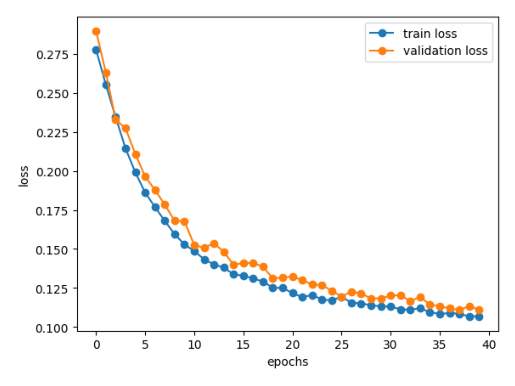

In [18]:
plt.plot(
    history.history["loss"],
    label="Training Loss",
    marker="o",
    markersize=8,
    linestyle="-",
    color="b",
)
plt.plot(
    history.history["val_loss"],
    label="Validation Loss",
    marker="o",
    markersize=8,
    linestyle="-",
    color="r",
)

plt.title("Training and Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)

plt.show()

In [55]:
train_eval = model.evaluate_generator(train_generator, steps=len(train_generator))
print(f"Train loss: {train_eval[0]}")
print(f"Train accuracy: {train_eval[1]*100}")

Train loss: 0.01070589479058981
Train accuracy: 90.31757872104644


In [56]:
val_eval = model.evaluate_generator(val_generator, steps=len(val_generator))
print(f"Train loss: {val_eval[0]}")
print(f"Train accuracy: {val_eval[1]*100}")

Validation loss: 0.0914650873094797
Validation accuracy: 83.16179585456848


# Predictions

In [14]:
detector = dlib.get_frontal_face_detector()


def preprocess_image(face_image):
    face_image = cv2.resize(face_image, (224, 224))
    face_image = piRes(face_image)
    face_image = np.expand_dims(face_image, axis=0)
    return face_image


def predict_age(preprocessed_face):
    model = load_model("best1.h5")

    class_labels = ["1-15", "16-25", "26-30", "31-35", "36-45", "46-60", "60-116"]

    predictions = model.predict(preprocessed_face)

    top_predicted_label = np.argmax(predictions)

    predicted_range = class_labels[top_predicted_label]

    return predicted_range


def get_actual_age_range(subfolder):
    if subfolder == "0":
        return "1-15"
    elif subfolder == "1":
        return "16-25"
    elif subfolder == "2":
        return "26-30"
    elif subfolder == "3":
        return "31-35"
    elif subfolder == "4":
        return "36-45"
    elif subfolder == "5":
        return "46-60"
    elif subfolder == "6":
        return "61-116"
    else:
        return "Unknown"


def test_age_prediction(image_path):
    image = cv2.imread(image_path)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = detector(gray_image)

    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        face_image = image[y : y + h, x : x + w]

        preprocessed_face = preprocess_image(face_image)

        age_category = predict_age(preprocessed_face)

        actual_age_range = get_actual_age_range(
            os.path.basename(os.path.dirname(image_path))
        )

        display(Image(filename=image_path, embed=True))

        print(f"Actual Age Range: {actual_age_range}")

        print(f"Predicted Age Range: {age_category}")

1/1 [==============================] - 0s 92ms/step


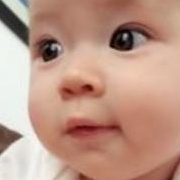

Actual Age Range: 1-15
Predicted Age Range: 1-15
1/1 [==============================] - 0s 98ms/step


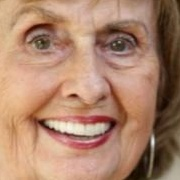

Actual Age Range: 61-116
Predicted Age Range: 61-116
1/1 [==============================] - 0s 88ms/step


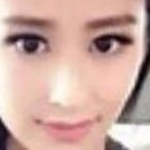

Actual Age Range: 16-25
Predicted Age Range: 16-25
1/1 [==============================] - 0s 96ms/step


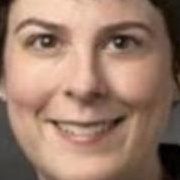

Actual Age Range: 36-45
Predicted Age Range: 36-45
1/1 [==============================] - 0s 97ms/step


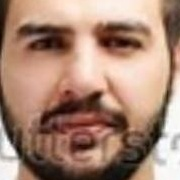

Actual Age Range: 31-35
Predicted Age Range: 31-35
1/1 [==============================] - 0s 97ms/step


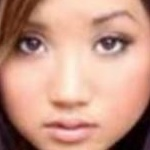

Actual Age Range: 26-30
Predicted Age Range: 26-30


In [15]:
dataset_path = "FacesDataset"

for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(subfolder_path):
        image_files = [
            f"{subfolder_path}/{img}"
            for img in os.listdir(subfolder_path)
            if img.endswith((".jpg", ".png", ".jpeg"))
        ]
        if image_files:
            random_image = random.choice(image_files)
            test_age_prediction(random_image)